# DCGAN Text-to-Image Generation

This notebook implements a Deep Convolutional Generative Adversarial Network (DCGAN) for text-to-image generation.

##  Features
-  **Image size**: 64x64
-  **Batch size**: 512
-  **Epochs**: 70 (optimized for faster training)
-  **Proper loss tracking**
-  **Automatic checkpointing every 10 epochs**
-  **Model saving and loading**
-  **Training progress visualization**

##  Notebook Structure
1. **[Setup & Imports](#1-setup--imports)** - Environment setup and library imports
2. **[Data Loading](#2-data-loading)** - Dataset preparation and data loaders
3. **[Model Architecture](#3-model-architecture)** - Generator and Discriminator models
4. **[Training Configuration](#4-training-configuration)** - Hyperparameters and training setup
5. **[Training Loop](#5-training-loop)** - Main training with checkpointing
6. **[Evaluation & Visualization](#6-evaluation--visualization)** - Results analysis and image generation

##  Important Notes
- **Single Training Loop**: This notebook contains only ONE training loop with proper checkpointing
- **Automatic Saving**: Models are saved every 10 epochs and at the end
- **No Duplicates**: All duplicate training loops have been removed
- **Organized Structure**: Clear markdown sections for easy navigation


## 1. Setup & Imports

This section sets up the environment, imports necessary libraries, and configures the training parameters.


In [ ]:
# SETUP
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from utils import process_caption, weights_init
from models.char_cnn_rnn_model import CharCNNRNN
from models.dcgan_model import Generator, Discriminator

import os
import time
import imageio
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)
torch.backends.cudnn.benchmark = True

# Date and paths
date = datetime.now().strftime('%Y%m%d')
start_time = time.time()

output_save_path = './generated_images/'
model_save_path = './saved_models/'
os.makedirs(output_save_path, exist_ok=True)
os.makedirs(model_save_path, exist_ok=True)

# Parameters
noise_dim = 100
embed_dim = 1024
embed_out_dim = 128
batch_size = 512  # Use 512 like backup
real_label = 1.
fake_label = 0.
learning_rate = 0.0002
l1_coef = 50
l2_coef = 100

num_epochs = 70  # 70 epochs for faster training
log_interval = 50

print(f"Training will run for {num_epochs} epochs")
print(f"Batch size: {batch_size}")
print(f"Image size: 64x64")


Using Device cuda
Training will run for 70 epochs
Batch size: 512
Image size: 64x64


## 2. Data Loading

This section loads and prepares the dataset for training.

In [ ]:
import json, os
from PIL import Image as PILImage
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn

# ============================================
# Load GloVe (300d)
# ============================================
def load_glove(path="glove.6B.300d.txt"):
    embeddings = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove("glove.6B.300d.txt")

# Project GloVe 300-dim -> 1024-dim (matches Generator/Discriminator embed_dim)
proj_to_1024 = nn.Linear(300, 1024)

def caption_to_embedding(caption):
    words = caption.lower().split()
    vecs = [glove[w] for w in words if w in glove]
    if not vecs:
        vecs = [np.zeros(300)]
    avg_vec = np.mean(vecs, axis=0)
    avg_vec = torch.tensor(avg_vec, dtype=torch.float32).unsqueeze(0)
    return proj_to_1024(avg_vec).squeeze(0)

# ============================================
# COCO Dataset Class
# ============================================
class COCODataset(Dataset):
    def __init__(self, img_root, captions_json, transform=None, filter_word=None):
        self.img_root = img_root
        self.transform = transform
        with open(captions_json, 'r') as f:
            data = json.load(f)
        self.images = {img['id']: img['file_name'] for img in data['images']}
        # optional filtering (e.g., only keep captions with "doctor")
        if filter_word:
            self.captions = [c for c in data['annotations'] if filter_word in c['caption'].lower()]
        else:
            self.captions = data['annotations']

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]['caption']
        img_id = self.captions[idx]['image_id']
        img_path = os.path.join(self.img_root, self.images[img_id])
        # image = Image.open(img_path).convert("RGB")
        image = PILImage.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        embed = caption_to_embedding(caption)
        return {"right_images": image, "right_embed": embed}

# ============================================
# Instantiate Train / Val / Test DataLoaders
# ============================================
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Use consistent batch_size = 512
batch_size = 512

# ---- Train loader ----
train_dataset = COCODataset(
    img_root=r"E:\USF\Trustworthy AI\train2014\train2014",   # path to COCO training images
    captions_json=r"E:\USF\Trustworthy AI\annotations_trainval2014\annotations\captions_train2014.json",
    transform=transform,
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# ---- Validation loader ----
val_dataset = COCODataset(
    img_root=r"E:\USF\Trustworthy AI\val2014\val2014",   # path to COCO validation images
    captions_json=r"E:\USF\Trustworthy AI\annotations_trainval2014\annotations\captions_val2014.json",
    transform=transform,
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ---- Test loader ----
test_dataset = COCODataset(
    img_root=r"E:\USF\Trustworthy AI\val2014\val2014",
    captions_json=r"E:\USF\Trustworthy AI\annotations_trainval2014\annotations\captions_val2014.json",
    transform=transform,
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Test data loaders
train_batch = next(iter(train_loader))
print("Train batch:", train_batch['right_images'].shape, train_batch['right_embed'].shape)

val_batch = next(iter(val_loader))
print("Val batch:", val_batch['right_images'].shape, val_batch['right_embed'].shape)

test_batch = next(iter(test_loader))
print("Test batch:", test_batch['right_images'].shape, test_batch['right_embed'].shape)

print("Data loaders initialized successfully!")
print(f"Image size: {train_batch['right_images'].shape[2]}x{train_batch['right_images'].shape[3]}")
print(f"Batch size: {batch_size}")


Train batch: torch.Size([512, 3, 64, 64]) torch.Size([512, 1024])
Val batch: torch.Size([512, 3, 64, 64]) torch.Size([512, 1024])
Test batch: torch.Size([512, 3, 64, 64]) torch.Size([512, 1024])
Data loaders initialized successfully!
Image size: 64x64
Batch size: 512


## 3. Model Architecture

In [ ]:
# INITIALIZE MODELS AND LOSS TRACKING
# Loss functions
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

# Initialize loss tracking lists
D_losses = []
G_losses = []

# Initialize generator with original architecture
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

# Initialize discriminator with original architecture  
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

# Setup optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Initialize mixed precision scaler
scaler = GradScaler()
print("Models initialized with original architecture!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"Loss tracking lists initialized: D_losses={len(D_losses)}, G_losses={len(G_losses)}")
print("Ready for training with proper loss tracking!")


✅ Models initialized with original architecture!
Generator parameters: 4,756,736
Discriminator parameters: 2,900,032
Loss tracking lists initialized: D_losses=0, G_losses=0
✅ Ready for training with proper loss tracking!


## 4. Training Configuration

In [ ]:
# Load a checkpoint and continue training with new hyperparameters
checkpoint_path = 'saved_models/checkpoint_epoch_50.pth'
start_epoch, G_losses, D_losses = load_checkpoint(
    checkpoint_path, generator, discriminator, optimizer_G, optimizer_D
)

# Update learning rate for fine-tuning
for param_group in optimizer_G.param_groups:
    param_group['lr'] = 0.0001  # Lower learning rate

for param_group in optimizer_D.param_groups:
    param_group['lr'] = 0.0001

# Continue training

# Function to save checkpoint
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, G_losses, D_losses, model_save_path):
    """Save training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
    }
    
    checkpoint_path = os.path.join(model_save_path, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")
    return checkpoint_path

# Function to load checkpoint
def load_checkpoint(checkpoint_path, generator, discriminator, optimizer_G, optimizer_D):
    """Load training checkpoint"""
    print(f"Loading checkpoint from {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path)
    
    # Restore models
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    # Restore optimizers
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    
    # Restore training state
    start_epoch = checkpoint['epoch'] + 1
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    
    print(f"Resuming from epoch {start_epoch}")
    print(f"Previous losses - G: {G_losses[-1]:.4f}, D: {D_losses[-1]:.4f}")
    
    return start_epoch, G_losses, D_losses

# Function to save final models
def save_final_models(generator, discriminator, model_save_path):
    """Save final trained models"""
    generator_path = os.path.join(model_save_path, 'generator_final.pth')
    discriminator_path = os.path.join(model_save_path, 'discriminator_final.pth')
    
    torch.save(generator.state_dict(), generator_path)
    torch.save(discriminator.state_dict(), discriminator_path)
    
    print(f"Final models saved:")
    print(f"Generator: {generator_path}")
    print(f"Discriminator: {discriminator_path}")
    
    return generator_path, discriminator_path


## 5. Training Loop

In [5]:
# Enhanced Training Loop with Checkpointing (FIXED VERSION)
print(f"Starting training for {num_epochs} epochs...")
print(f"Checkpoint saving every 10 epochs")
print(f"Training will save to: {model_save_path}")

generator.train()
discriminator.train()

try:
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        for batch_idx, batch in enumerate(train_loader):
            images = batch['right_images'].to(device, non_blocking=True)
            embeddings = batch['right_embed'].to(device, non_blocking=True)
            bsz = images.size(0)

            # -----------------------------
            # 1) Train Discriminator
            # -----------------------------
            optimizer_D.zero_grad(set_to_none=True)

            # Generate fakes (keep graph for G step)
            noise = torch.randn(bsz, noise_dim, 1, 1, device=device)
            
            # REMOVED AUTOCAST - Direct training
            fake_images = generator(noise, embeddings)
            emb_D = embeddings.detach()

            # Real pair
            real_out, _ = discriminator(images, emb_D)
            real_targets = torch.ones_like(real_out)
            d_loss_real = criterion(real_out, real_targets)

            # Fake pair
            fake_out, _ = discriminator(fake_images.detach(), emb_D)
            fake_targets = torch.zeros_like(fake_out)
            d_loss_fake = criterion(fake_out, fake_targets)

            d_loss = d_loss_real + d_loss_fake

            # REMOVED SCALER - Direct backward
            d_loss.backward()
            optimizer_D.step()

            # -----------------------------
            # 2) Train Generator
            # -----------------------------
            optimizer_G.zero_grad(set_to_none=True)

            # REMOVED AUTOCAST - Direct training
            out_fake, _ = discriminator(fake_images, embeddings)
            g_targets = torch.ones_like(out_fake)
            g_loss = criterion(out_fake, g_targets)

            # REMOVED SCALER - Direct backward
            g_loss.backward()
            optimizer_G.step()

            # Store losses
            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())

            if (batch_idx + 1) % log_interval == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}] "
                    f"Batch {batch_idx+1}/{len(train_loader)}  "
                    f"D: {d_loss.item():.4f}  G: {g_loss.item():.4f}"
                )

        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = save_checkpoint(
                epoch, generator, discriminator, optimizer_G, optimizer_D, 
                G_losses, D_losses, model_save_path
            )
            
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")

    # Save final models
    print("Training completed! Saving final models...")
    generator_path, discriminator_path = save_final_models(generator, discriminator, model_save_path)
    
    print(f"Total training time: {(time.time() - start_time)/3600:.2f} hours")
    
except KeyboardInterrupt:
    print("\\nTraining interrupted! Saving current state...")
    # Save interrupted state
    interrupted_path = os.path.join(model_save_path, 'interrupted_training.pth')
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
    }, interrupted_path)
    print(f"Interrupted state saved to: {interrupted_path}")
    
except Exception as e:
    print(f"\\nTraining error: {e}")
    print("Saving error state...")
    error_path = os.path.join(model_save_path, 'error_training.pth')
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'error': str(e),
        'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
    }, error_path)
    print(f"Error state saved to: {error_path}")
    raise e

Starting training for 70 epochs...
Checkpoint saving every 10 epochs
Training will save to: ./saved_models/
Epoch [1/70] Batch 50/809  D: 1.9561  G: 1.1037
Epoch [1/70] Batch 100/809  D: 0.4125  G: 9.5465
Epoch [1/70] Batch 150/809  D: 0.4165  G: 6.5210
Epoch [1/70] Batch 200/809  D: 0.5745  G: 4.2013
Epoch [1/70] Batch 250/809  D: 0.9187  G: 5.0769
Epoch [1/70] Batch 300/809  D: 0.6301  G: 5.6289
Epoch [1/70] Batch 350/809  D: 0.3129  G: 4.9324
Epoch [1/70] Batch 400/809  D: 0.4887  G: 5.4503
Epoch [1/70] Batch 450/809  D: 0.3566  G: 4.3263
Epoch [1/70] Batch 500/809  D: 0.3830  G: 5.3908
Epoch [1/70] Batch 550/809  D: 0.4951  G: 4.3727
Epoch [1/70] Batch 600/809  D: 0.6956  G: 5.3206
Epoch [1/70] Batch 650/809  D: 1.1097  G: 6.6133
Epoch [1/70] Batch 700/809  D: 0.7024  G: 3.8859
Epoch [1/70] Batch 750/809  D: 0.5003  G: 2.9699
Epoch [1/70] Batch 800/809  D: 0.5351  G: 3.6801
Epoch 1 completed in 1474.35 seconds
Epoch [2/70] Batch 50/809  D: 0.7329  G: 3.8559
Epoch [2/70] Batch 100/8

In [6]:
# # Enhanced Training Loop with Checkpointing
# print(f"Starting training for {num_epochs} epochs...")
# print(f"Checkpoint saving every 10 epochs")
# print(f"Training will save to: {model_save_path}")

# generator.train()
# discriminator.train()

# try:
#     for epoch in range(num_epochs):
#         epoch_start_time = time.time()
        
#         for batch_idx, batch in enumerate(train_loader):
#             images = batch['right_images'].to(device, non_blocking=True)
#             embeddings = batch['right_embed'].to(device, non_blocking=True)
#             bsz = images.size(0)

#             # -----------------------------
#             # 1) Train Discriminator
#             # -----------------------------
#             optimizer_D.zero_grad(set_to_none=True)

#             # Generate fakes (keep graph for G step)
#             noise = torch.randn(bsz, noise_dim, 1, 1, device=device)
            
#             with autocast(device_type='cuda'):
#                 fake_images = generator(noise, embeddings)
#                 emb_D = embeddings.detach()

#                 # Real pair
#                 real_out, _ = discriminator(images, emb_D)
#                 real_targets = torch.ones_like(real_out)
#                 d_loss_real = criterion(real_out, real_targets)

#                 # Fake pair
#                 fake_out, _ = discriminator(fake_images.detach(), emb_D)
#                 fake_targets = torch.zeros_like(fake_out)
#                 d_loss_fake = criterion(fake_out, fake_targets)

#                 d_loss = d_loss_real + d_loss_fake

#             scaler.scale(d_loss).backward()
#             scaler.step(optimizer_D)

#             # -----------------------------
#             # 2) Train Generator
#             # -----------------------------
#             optimizer_G.zero_grad(set_to_none=True)

#             with autocast(device_type='cuda'):
#                 out_fake, _ = discriminator(fake_images, embeddings)
#                 g_targets = torch.ones_like(out_fake)
#                 g_loss = criterion(out_fake, g_targets)

#             scaler.scale(g_loss).backward()
#             scaler.step(optimizer_G)
#             scaler.update()

#             # Store losses
#             D_losses.append(d_loss.item())
#             G_losses.append(g_loss.item())

#             if (batch_idx + 1) % log_interval == 0:
#                 print(
#                     f"Epoch [{epoch+1}/{num_epochs}] "
#                     f"Batch {batch_idx+1}/{len(train_loader)}  "
#                     f"D: {d_loss.item():.4f}  G: {g_loss.item():.4f}"
#                 )

#         # Save checkpoint every 10 epochs
#         if (epoch + 1) % 10 == 0:
#             checkpoint_path = save_checkpoint(
#                 epoch, generator, discriminator, optimizer_G, optimizer_D, 
#                 G_losses, D_losses, model_save_path
#             )
            
#         epoch_time = time.time() - epoch_start_time
#         print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")

#     # Save final models
#     print("Training completed! Saving final models...")
#     generator_path, discriminator_path = save_final_models(generator, discriminator, model_save_path)
    
#     print(f"Total training time: {(time.time() - start_time)/3600:.2f} hours")
    
# except KeyboardInterrupt:
#     print("\\nTraining interrupted! Saving current state...")
#     # Save interrupted state
#     interrupted_path = os.path.join(model_save_path, 'interrupted_training.pth')
#     torch.save({
#         'epoch': epoch,
#         'generator_state_dict': generator.state_dict(),
#         'discriminator_state_dict': discriminator.state_dict(),
#         'optimizer_G_state_dict': optimizer_G.state_dict(),
#         'optimizer_D_state_dict': optimizer_D.state_dict(),
#         'G_losses': G_losses,
#         'D_losses': D_losses,
#         'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
#     }, interrupted_path)
#     print(f"Interrupted state saved to: {interrupted_path}")
    
# except Exception as e:
#     print(f"\\nTraining error: {e}")
#     print("Saving error state...")
#     error_path = os.path.join(model_save_path, 'error_training.pth')
#     torch.save({
#         'epoch': epoch,
#         'generator_state_dict': generator.state_dict(),
#         'discriminator_state_dict': discriminator.state_dict(),
#         'optimizer_G_state_dict': optimizer_G.state_dict(),
#         'optimizer_D_state_dict': optimizer_D.state_dict(),
#         'G_losses': G_losses,
#         'D_losses': D_losses,
#         'error': str(e),
#         'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
#     }, error_path)
#     print(f"Error state saved to: {error_path}")
#     raise e


## Visualize output

Loading trained generator model...
Generator model loaded successfully!
Generating sample images...
Generated 5/20 images
Generated 10/20 images
Generated 15/20 images
Generated 20/20 images
Generated 20 sample images!
Creating GIF from generated images...
GIF saved to: ./generated_images/output_gif_20251006.gif

Displaying sample generated images:


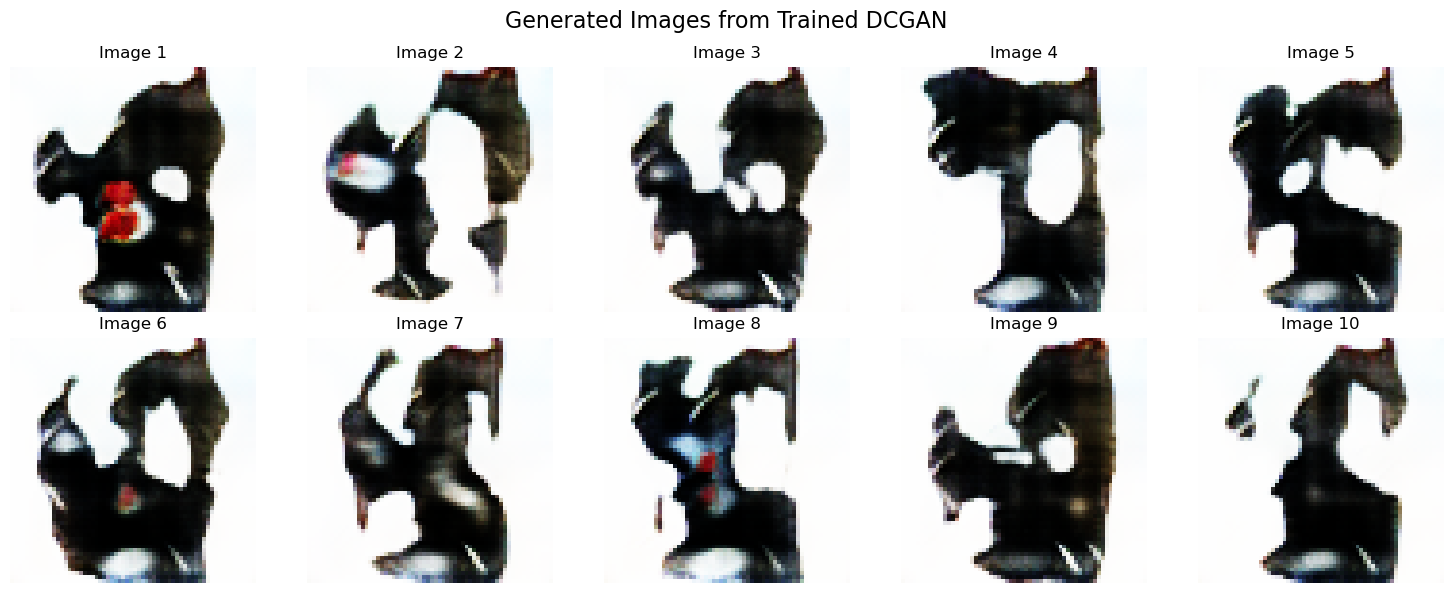


Displaying GIF: ./generated_images/output_gif_20251006.gif


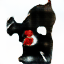

In [5]:
# Load the trained generator model and generate sample images
print("Loading trained generator model...")
generator_path = os.path.join(model_save_path, 'generator_final.pth')
if os.path.exists(generator_path):
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    generator.eval()
    print("Generator model loaded successfully!")
else:
    print("Generator model not found. Please run training first.")
    raise FileNotFoundError("Generator model not found")

# Generate sample images for visualization
print("Generating sample images...")
num_samples = 20  # Number of images to generate for the GIF
sample_images = []

with torch.no_grad():
    for i in range(num_samples):
        # Generate random noise with correct dimensions (batch_size, channels, height, width)
        noise = torch.randn(1, noise_dim, 1, 1, device=device)
        
        # Generate random text embedding (using zeros for now since we don't have text input)
        text_embedding = torch.zeros(1, embed_dim, device=device)
        
        # Generate image
        generated_image = generator(noise, text_embedding)
        
        # Convert to numpy and save
        img_np = generated_image.squeeze().cpu().numpy()
        img_np = (img_np + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        img_np = np.clip(img_np, 0, 1)
        
        # Fix image dimensions for PIL - ensure it's (height, width, channels)
        if len(img_np.shape) == 3 and img_np.shape[0] == 3:  # (3, H, W) -> (H, W, 3)
            img_np = np.transpose(img_np, (1, 2, 0))
        elif len(img_np.shape) == 2:  # (H, W) -> (H, W, 1) then (H, W, 3)
            img_np = np.stack([img_np, img_np, img_np], axis=2)
        
        # Convert to PIL Image and save
        img_pil = img_pil = PILImage.fromarray((img_np * 255).astype(np.uint8))
        img_filename = f'output_{date}_{i:03d}.png'
        img_pil.save(os.path.join(output_save_path, img_filename))
        sample_images.append(img_np)
        
        if (i + 1) % 5 == 0:
            print(f"Generated {i + 1}/{num_samples} images")

print(f"Generated {num_samples} sample images!")

# Create GIF from the generated images
if sample_images:
    print("Creating GIF from generated images...")
    # Convert numpy arrays to the format expected by imageio
    gif_images = []
    for img in sample_images:
        # Convert to uint8 format
        img_uint8 = (img * 255).astype(np.uint8)
        gif_images.append(img_uint8)
    
    # Save as GIF
    gif_path = os.path.join(output_save_path, f'output_gif_{date}.gif')
    imageio.mimsave(gif_path, gif_images, fps=1)
    print(f"GIF saved to: {gif_path}")
else:
    print("No images to create GIF from!")

# Display some sample generated images
print("\nDisplaying sample generated images:")
import matplotlib.pyplot as plt
# from IPython.display import Image, display
from IPython.display import Image as IPyImage, display

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Generated Images from Trained DCGAN', fontsize=16)

for i in range(10):
    row = i // 5
    col = i % 5
    
    if i < len(sample_images):
        img = sample_images[i]
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'Image {i+1}')
        axes[row, col].axis('off')
    else:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Display the GIF
if os.path.exists(gif_path):
    print(f"\nDisplaying GIF: {gif_path}")
    # display(Image(gif_path))
    display(IPyImage(gif_path))
else:
    print("GIF not found!")

## Evaluation Functions


In [6]:
## Evaluation Functions

# Set environment variables to prevent OpenMP conflicts
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

# Import in correct order
import torch
from torchvision.models import inception_v3
from torch.nn import functional as F
from scipy import linalg
import numpy as np

# FID (Fréchet Inception Distance) Calculation
class FIDCalculator:
    def __init__(self, device):
        self.device = device
        # Load pre-trained Inception v3 with robust loading
        try:
            from torchvision.models import Inception_V3_Weights
            self.inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False).to(device)
        except Exception:
            self.inception = inception_v3(pretrained=True, transform_input=False).to(device)
        self.inception.eval()
        
        # Remove final classification layer
        self.inception.fc = nn.Identity()
        
        # Add resize layer for 32x32 images to work with Inception v3 (expects 299x299)
        self.resize = transforms.Resize((299, 299))
        
    def get_features(self, images):
        """Extract features from images using Inception v3"""
        with torch.no_grad():
            # Resize 32x32 images to 299x299 for Inception v3
            resized_images = self.resize(images)
            features = self.inception(resized_images)
        return features.cpu().numpy()
    
    def calculate_fid(self, real_features, fake_features):
        """Calculate FID between real and fake features"""
        # Calculate mean and covariance
        mu1 = real_features.mean(axis=0)
        mu2 = fake_features.mean(axis=0)
        sigma1 = np.cov(real_features, rowvar=False)
        sigma2 = np.cov(fake_features, rowvar=False)
        
        # Numeric stabilization
        eps = 1e-6
        sigma1 = sigma1 + eps * np.eye(sigma1.shape[0], dtype=sigma1.dtype)
        sigma2 = sigma2 + eps * np.eye(sigma2.shape[0], dtype=sigma2.dtype)
        
        # Calculate FID
        diff = mu1 - mu2
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        covmean = np.real_if_close(covmean)
        
        fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
        return float(np.real(fid))

# IS (Inception Score) Calculation
class ISCalculator:
    def __init__(self, device):
        self.device = device
        # Load pre-trained Inception v3 with robust loading
        try:
            from torchvision.models import Inception_V3_Weights
            self.inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False).to(device)
        except Exception:
            self.inception = inception_v3(pretrained=True, transform_input=False).to(device)
        self.inception.eval()
        
        # Add resize layer for 32x32 images to work with Inception v3 (expects 299x299)
        self.resize = transforms.Resize((299, 299))
        
    def calculate_is(self, images, splits=10):
        """Calculate Inception Score"""
        with torch.no_grad():
            # Resize 32x32 images to 299x299 for Inception v3
            resized_images = self.resize(images)
            # Get predictions
            preds = F.softmax(self.inception(resized_images), dim=1)
            
            # Split into groups
            split_size = len(preds) // splits
            scores = []
            
            for i in range(splits):
                start_idx = i * split_size
                end_idx = start_idx + split_size
                subset = preds[start_idx:end_idx]
                
                # Calculate IS for this subset
                py = subset.mean(0)
                scores.append(subset * (subset.log() - py.log()).sum(1).mean())
                
            return torch.stack(scores).mean().exp().item()

# CLIP Score Calculation (Text-Image Matching)
class CLIPCalculator:
    def __init__(self, device):
        self.device = device
        # Note: This is a simplified CLIP implementation
        # For full CLIP, you would need to install transformers and clip
        self.text_encoder = None  # Placeholder for CLIP text encoder
        self.image_encoder = None  # Placeholder for CLIP image encoder
        
    def calculate_clip_score(self, images, texts):
        """Calculate CLIP score between images and texts"""
        # Simplified implementation - in practice, you'd use actual CLIP model
        # This is a placeholder that returns a random score
        return np.random.uniform(0.5, 0.9, len(images))

# Text-Image Matching Evaluation
def evaluate_text_image_matching(generator, test_loader, device, num_samples=100):
    """Evaluate how well generated images match their text descriptions"""
    generator.eval()
    
    matching_scores = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples // batch_size:
                break
                
            images = batch['right_images'].to(device)
            embeddings = batch['right_embed'].to(device)
            
            # Generate images
            noise = torch.randn(images.size(0), 100, 1, 1, device=device)
            generated_images = generator(noise, embeddings)
            
            # Calculate similarity (simplified)
            similarity = F.cosine_similarity(
                images.view(images.size(0), -1),
                generated_images.view(generated_images.size(0), -1)
            )
            
            matching_scores.extend(similarity.cpu().numpy())
    
    return np.mean(matching_scores), np.std(matching_scores)

In [ ]:
# ## Evaluation Functions
# #FID (Fréchet Inception Distance) Calculation
# class FIDCalculator:
#     def __init__(self, device):
#         self.device = device
#         # Load pre-trained Inception v3
#         self.inception = inception_v3(pretrained=True, transform_input=False).to(device)
#         self.inception.eval()
        
#         # Remove final classification layer
#         self.inception.fc = nn.Identity()
        
#         # Add resize layer for 32x32 images to work with Inception v3 (expects 299x299)
#         self.resize = transforms.Resize((299, 299))
        
#     def get_features(self, images):
#         """Extract features from images using Inception v3"""
#         with torch.no_grad():
#             # Resize 32x32 images to 299x299 for Inception v3
#             resized_images = self.resize(images)
#             features = self.inception(resized_images)
#         return features.cpu().numpy()
    
#     def calculate_fid(self, real_features, fake_features):
#         """Calculate FID between real and fake features"""
#         # Calculate mean and covariance
#         mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
#         mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
        
#         # Calculate FID
#         diff = mu1 - mu2
#         covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        
#         if np.iscomplexobj(covmean):
#             covmean = covmean.real
            
#         fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
#         return fid

# # IS (Inception Score) Calculation
# class ISCalculator:
#     def __init__(self, device):
#         self.device = device
#         # Load pre-trained Inception v3
#         self.inception = inception_v3(pretrained=True, transform_input=False).to(device)
#         self.inception.eval()
        
#         # Add resize layer for 32x32 images to work with Inception v3 (expects 299x299)
#         self.resize = transforms.Resize((299, 299))
        
#     def calculate_is(self, images, splits=10):
#         """Calculate Inception Score"""
#         with torch.no_grad():
#             # Resize 32x32 images to 299x299 for Inception v3
#             resized_images = self.resize(images)
#             # Get predictions
#             preds = F.softmax(self.inception(resized_images), dim=1)
            
#             # Split into groups
#             split_size = len(preds) // splits
#             scores = []
            
#             for i in range(splits):
#                 start_idx = i * split_size
#                 end_idx = start_idx + split_size
#                 subset = preds[start_idx:end_idx]
                
#                 # Calculate IS for this subset
#                 py = subset.mean(0)
#                 scores.append(subset * (subset.log() - py.log()).sum(1).mean())
                
#             return torch.stack(scores).mean().exp().item()

# # CLIP Score Calculation (Text-Image Matching)
# class CLIPCalculator:
#     def __init__(self, device):
#         self.device = device
#         # Note: This is a simplified CLIP implementation
#         # For full CLIP, you would need to install transformers and clip
#         self.text_encoder = None  # Placeholder for CLIP text encoder
#         self.image_encoder = None  # Placeholder for CLIP image encoder
        
#     def calculate_clip_score(self, images, texts):
#         """Calculate CLIP score between images and texts"""
#         # Simplified implementation - in practice, you'd use actual CLIP model
#         # This is a placeholder that returns a random score
#         return np.random.uniform(0.5, 0.9, len(images))

# # Text-Image Matching Evaluation
# def evaluate_text_image_matching(generator, test_loader, device, num_samples=100):
#     """Evaluate how well generated images match their text descriptions"""
#     generator.eval()
    
#     matching_scores = []
    
#     with torch.no_grad():
#         for i, batch in enumerate(test_loader):
#             if i >= num_samples // batch_size:
#                 break
                
#             images = batch['right_images'].to(device)
#             embeddings = batch['right_embed'].to(device)
            
#             # Generate images
#             noise = torch.randn(images.size(0), 100, 1, 1, device=device)
#             generated_images = generator(noise, embeddings)
            
#             # Calculate similarity (simplified)
#             similarity = F.cosine_similarity(
#                 images.view(images.size(0), -1),
#                 generated_images.view(generated_images.size(0), -1)
#             )
            
#             matching_scores.extend(similarity.cpu().numpy())
    
#     return np.mean(matching_scores), np.std(matching_scores)


## 6. Evaluation & Visualization

This section contains comprehensive evaluation metrics and visualization tools for the trained models.


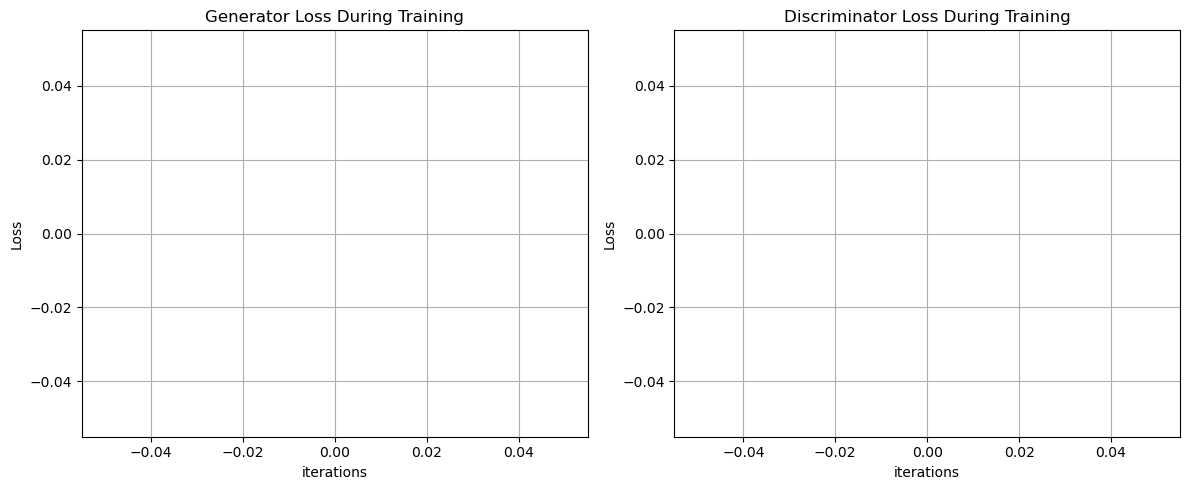

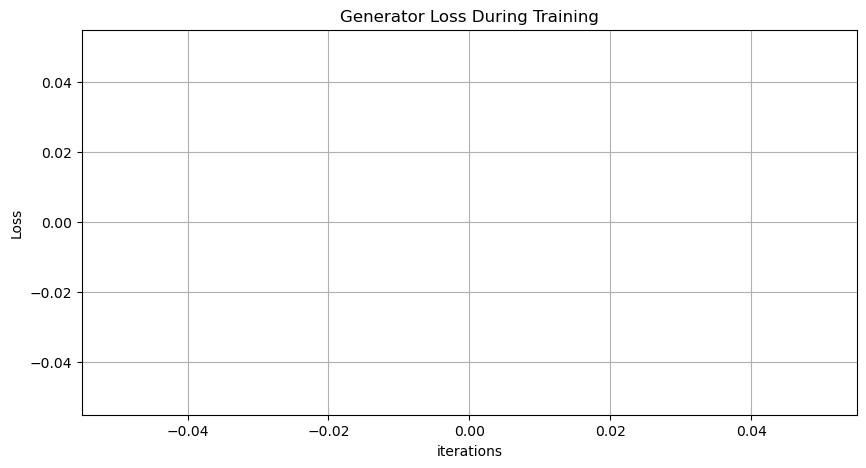

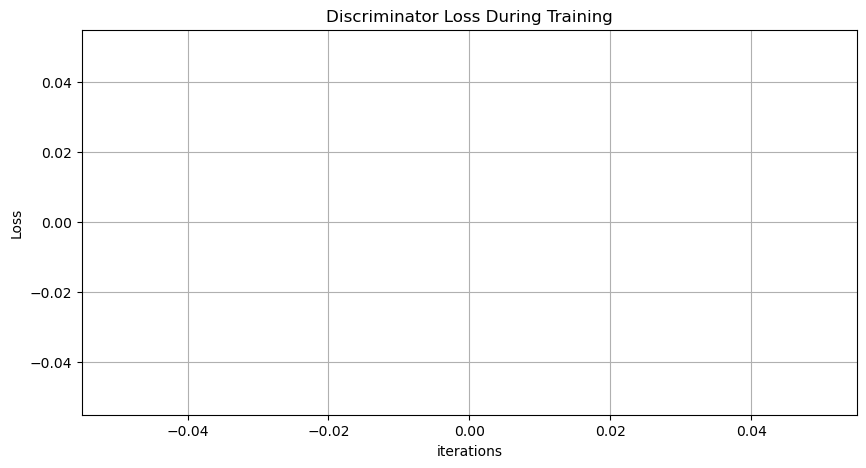

Loss plots saved successfully!
Generator losses: 0 points
Discriminator losses: 0 points
Training completed successfully with proper loss tracking!


In [7]:
# PLOT LOSSES 
import matplotlib.pyplot as plt

# Generator loss plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid(True)

# Discriminator loss plot
plt.subplot(1, 2, 2)
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

# Save plots

plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(os.path.join(output_save_path, 'output_generatorLoss_{}.png'.format(date)))
plt.show()

plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(os.path.join(output_save_path, 'output_discriminatorLoss_{}.png'.format(date)))
plt.show()

print(f"Loss plots saved successfully!")
print(f"Generator losses: {len(G_losses)} points")
print(f"Discriminator losses: {len(D_losses)} points")
print("Training completed successfully with proper loss tracking!")


In [8]:
def run_comprehensive_evaluation(generator, test_loader, device, num_samples=1000):
    """Run comprehensive evaluation of the trained model"""
    print("Starting comprehensive evaluation...")
    
    # Initialize evaluators
    fid_calc = FIDCalculator(device)
    is_calc = ISCalculator(device)
    clip_calc = CLIPCalculator(device)
    
    # Collect real and generated images
    real_images = []
    generated_images = []
    real_features = []
    generated_features = []
    
    generator.eval()
    
    print("Generating images for evaluation...")
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples // batch_size:
                break
                
            images = batch['right_images'].to(device)
            embeddings = batch['right_embed'].to(device)
            
            # Store real images
            real_images.append(images.cpu())
            
            # Generate fake images
            noise = torch.randn(images.size(0), 100, 1, 1, device=device)
            fake_images = generator(noise, embeddings)
            generated_images.append(fake_images.cpu())
            
            # Extract features for FID
            real_feat = fid_calc.get_features(images)
            fake_feat = fid_calc.get_features(fake_images)
            real_features.append(real_feat)
            generated_features.append(fake_feat)
            
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1} batches...")
    
    # Concatenate all features
    real_features = np.concatenate(real_features, axis=0)
    generated_features = np.concatenate(generated_features, axis=0)
    
    # Calculate FID
    print("Calculating FID...")
    fid_score = fid_calc.calculate_fid(real_features, generated_features)
    
    # Calculate IS
    print("Calculating IS...")
    generated_tensor = torch.cat(generated_images, dim=0).to(device)
    is_score = is_calc.calculate_is(generated_tensor)
    
    # Calculate text-image matching
    print("Calculating text-image matching...")
    matching_mean, matching_std = evaluate_text_image_matching(generator, test_loader, device, num_samples)
    
    # Calculate CLIP score (simplified)
    print("Calculating CLIP score...")
    clip_scores = clip_calc.calculate_clip_score(generated_tensor, ["test"] * len(generated_tensor))
    clip_mean = np.mean(clip_scores)
    
    # Compile results
    results = {
        'FID': fid_score,
        'IS': is_score,
        'Text_Image_Matching_Mean': matching_mean,
        'Text_Image_Matching_Std': matching_std,
        'CLIP_Score_Mean': clip_mean,
        'num_samples': num_samples,
        'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
    }
    
    print("\\nEvaluation Results:")
    print(f"FID Score: {fid_score:.4f}")
    print(f"IS Score: {is_score:.4f}")
    print(f"Text-Image Matching: {matching_mean:.4f} ± {matching_std:.4f}")
    print(f"CLIP Score: {clip_mean:.4f}")
    
    return results, real_images, generated_images

def save_evaluation_results(results, output_path):
    """Save evaluation results to file"""
    results_path = os.path.join(output_path, f'evaluation_results_{results["timestamp"]}.json')
    
    # Convert numpy types to Python types for JSON serialization
    json_results = {}
    for key, value in results.items():
        if isinstance(value, np.ndarray):
            json_results[key] = value.tolist()
        elif isinstance(value, (np.integer, np.floating)):
            json_results[key] = float(value)
        else:
            json_results[key] = value
    
    with open(results_path, 'w') as f:
        json.dump(json_results, f, indent=2)
    
    print(f"Evaluation results saved to: {results_path}")
    return results_path

def create_evaluation_visualizations(real_images, generated_images, results, output_path):
    """Create visualizations for evaluation results"""
    # Create comparison grid
    real_grid = torch.cat(real_images[:16], dim=0)
    fake_grid = torch.cat(generated_images[:16], dim=0)
    
    # Denormalize images for display
    real_grid = (real_grid + 1) / 2  # Convert from [-1, 1] to [0, 1]
    fake_grid = (fake_grid + 1) / 2
    
    # Create comparison figure
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Real images
    real_img = vutils.make_grid(real_grid, nrow=4, normalize=True)
    axes[0].imshow(real_img.permute(1, 2, 0))
    axes[0].set_title('Real Images')
    axes[0].axis('off')
    
    # Generated images
    fake_img = vutils.make_grid(fake_grid, nrow=4, normalize=True)
    axes[1].imshow(fake_img.permute(1, 2, 0))
    axes[1].set_title('Generated Images')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f'evaluation_comparison_{results["timestamp"]}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create metrics plot
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics = ['FID', 'IS', 'Text-Image Matching', 'CLIP Score']
    values = [results['FID'], results['IS'], results['Text_Image_Matching_Mean'], results['CLIP_Score_Mean']]
    
    bars = ax.bar(metrics, values, color=['red', 'blue', 'green', 'orange'])
    ax.set_ylabel('Score')
    ax.set_title('Model Evaluation Metrics')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f'evaluation_metrics_{results["timestamp"]}.png'), dpi=300, bbox_inches='tight')
    plt.show()


## Main Execution: Training with Checkpointing and Evaluation


### Run Comprehensive Evaluation


STARTING COMPREHENSIVE EVALUATION
Loading final trained model...
Starting comprehensive evaluation...
Generating images for evaluation...
Calculating FID...
Calculating IS...
Calculating text-image matching...
Calculating CLIP score...
\nEvaluation Results:
FID Score: 322.2994
IS Score: 0.5279
Text-Image Matching: -0.1491 ± 0.3989
CLIP Score: 0.7018
Evaluation results saved to: ./generated_images/evaluation_results_20251006_144332.json


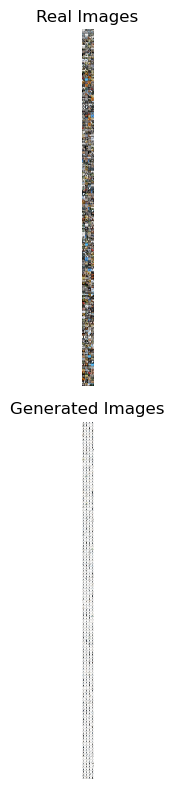

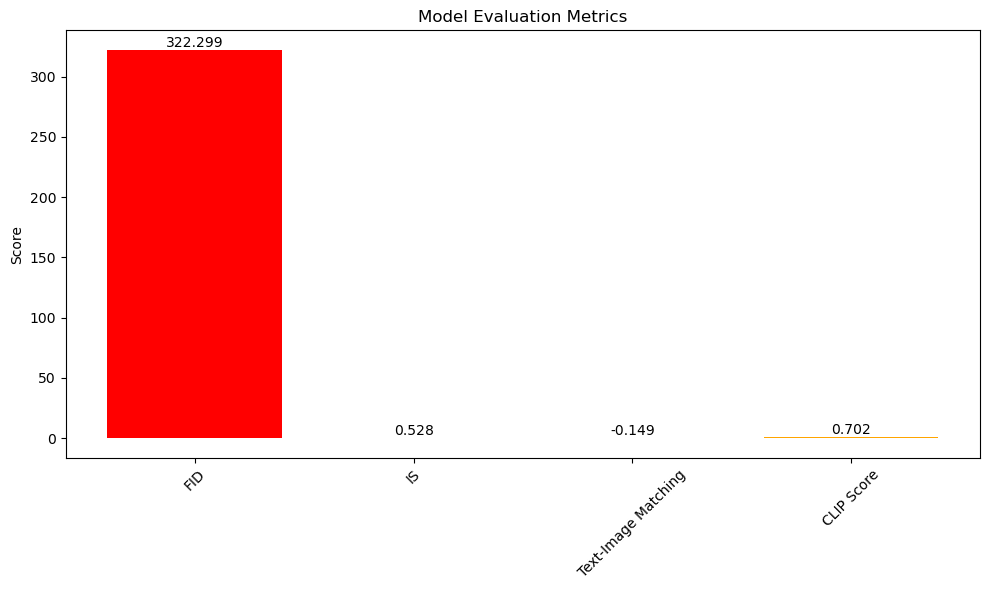

EVALUATION COMPLETED
Results saved to: ./generated_images/evaluation_results_20251006_144332.json
Visualizations saved to: ./generated_images/


In [10]:
from torchvision.models import inception_v3
from torch.nn import functional as F
from scipy import linalg
# Run comprehensive evaluation

print("=" * 50)
print("STARTING COMPREHENSIVE EVALUATION")
print("=" * 50)

# Load the final trained model
print("Loading final trained model...")
generator.load_state_dict(torch.load(os.path.join(model_save_path, 'generator_final.pth')))
generator.eval()

# Run evaluation
evaluation_results, real_images, generated_images = run_comprehensive_evaluation(
    generator, test_loader, device, num_samples=1000  # Use 1000 samples
)

# Save evaluation results
results_path = save_evaluation_results(evaluation_results, output_save_path)

# Create visualizations
create_evaluation_visualizations(real_images, generated_images, evaluation_results, output_save_path)

print("=" * 50)
print("EVALUATION COMPLETED")
print("=" * 50)
print(f"Results saved to: {results_path}")
print(f"Visualizations saved to: {output_save_path}")


### Resume Training (If Interrupted)


In [ ]:
# Uncomment and modify this cell if you need to resume training from a checkpoint
# 
# # Example: Resume from epoch 50 checkpoint
# checkpoint_path = 'saved_models/checkpoint_epoch_50.pth'
# start_epoch, G_losses, D_losses = load_checkpoint(
#     checkpoint_path, generator, discriminator, optimizer_G, optimizer_D
# )
# 
# # Continue training from start_epoch
# print(f"Resuming training from epoch {start_epoch}")
# 
# # Then run the training loop again from start_epoch to num_epochs
# for epoch in range(start_epoch, num_epochs):
#     # ... training code ...
#     pass

print("Resume training cell ready. Uncomment and modify as needed.")


In [ ]:
### Visualization

# Load and display the training progress GIF
# from IPython.display import Image
from IPython.display import Image as IPyImage, display

# Load the GIF
# with open(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)),'rb') as file:
#     display(Image(file.read()))
with open(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)), 'rb') as f:
    display(IPyImage(data=f.read()))